In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split

import matplotlib.pyplot as plt


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss


In [3]:
tmp_538 = pd.read_csv('../data/fivethirtyeight_2016.csv')

### Create data

In [4]:
regular_season_results = pd.read_csv('../data/MRegularSeasonDetailedResults.csv')
detailed_tourney_results = pd.read_csv('../data/MNCAATourneyDetailedResults.csv')
rankings = pd.read_csv('../data/MMasseyOrdinals.csv')
seeds = pd.read_csv('../data/MNCAATourneySeeds.csv')

kp_rankings = pd.read_csv('../data/kenpom_pre_tourney_snapshot.csv')

regular_season_results_w = pd.read_csv('../data/WRegularSeasonDetailedResults.csv')
detailed_tourney_results_w = pd.read_csv('../data/WNCAATourneyDetailedResults.csv')
seeds_w = pd.read_csv('../data/WNCAATourneySeeds.csv')

# _538_df = pd.read_csv('../data/all_538.csv')

M538 = pd.read_csv('../data/M538.csv')
W538 = pd.read_csv('../data/W538.csv')


In [5]:
base_w = preprocess.PreProcess(detailed_tourney_results_w, regular_season_results_w).process()
base = preprocess.PreProcess(detailed_tourney_results, regular_season_results).process()

In [6]:
tourney_games = base[base.TourneyGame == 1]
regular_season_games = base[base.TourneyGame == 0]

tourney_games_w = base_w[base_w.TourneyGame == 1]
regular_season_games_w = base_w[base_w.TourneyGame == 0]

In [7]:
sub = pd.read_csv('../data/SampleSubmission2023.csv')


In [8]:
mteams = pd.read_csv('../data/MTeams.csv')
wteams = pd.read_csv('../data/WTeams.csv')
to_predict=submission.SubmissionSetup(sub, tourney_games, tourney_games_w, mteams.copy()).setup()

to_predict_mens = to_predict[to_predict.Gender == 'M'].copy()
to_predict_womens = to_predict[to_predict.Gender == 'W'].copy()

In [11]:
to_predict_womens = feature_engineering.TournamentSeed(tourney_seeds=seeds_w).add(to_predict_womens)
to_predict_womens = feature_engineering.Efficiency(games=regular_season_games_w, away_bonus=0).add(to_predict_womens)
to_predict_womens = feature_engineering.FiveThirtyEight(fivethirtyeight_df=W538).add(to_predict_womens)

In [12]:
to_predict_mens = feature_engineering.FiveThirtyEight(fivethirtyeight_df=M538).add(to_predict_mens)
to_predict_mens = feature_engineering.PreSeasonAPRankings(rankings_df=rankings).add(to_predict_mens)
to_predict_mens = feature_engineering.TournamentSeed(tourney_seeds=seeds).add(to_predict_mens)
to_predict_mens = feature_engineering.Efficiency(games=regular_season_games, away_bonus=0).add(to_predict_mens)
to_predict_mens = feature_engineering.FinalRanking(rankings_df=rankings, system='SAG').add(to_predict_mens)
to_predict_mens = feature_engineering.Kenpom(kp_snapshot=kp_rankings).add(to_predict_mens)
to_predict_mens = feature_engineering.FiveThirtyEight(fivethirtyeight_df=M538).add(to_predict_mens)

In [39]:
to_predict_mens.to_csv("to_predict_mens.csv")

### Analysis - Using Original Features

In [13]:
train = to_predict_mens[to_predict_mens.Season < 2017]
test = to_predict_mens[to_predict_mens.Season >= 2017]

features_sky_mens = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

scaler = MinMaxScaler()
train[features_sky_mens] = scaler.fit_transform(train[features_sky_mens])
target = 'Outcome'

train[target] = train[target].astype(int)


In [42]:
hidden_layer_sizes = [(0,), (5,), (25,), (100,), (100, 50), (24, 12), (48, 24, 12)]

results = []

for hls in hidden_layer_sizes:

    if hls == (0,):
        model = MLPClassifier(hidden_layer_sizes=(), max_iter=1000, random_state=23)
    else:
        model = MLPClassifier(hidden_layer_sizes=hls, max_iter=1000, random_state=23)

    scores = cross_validate(model, train[features_sky_mens], train[target].astype(int), cv=5, scoring='neg_brier_score', return_train_score=True)
    cv_score = sum(scores['test_score']) / len(scores['test_score'])
    train_score = sum(scores['train_score']) / len(scores['train_score'])

    results.append((hls, cv_score, train_score))

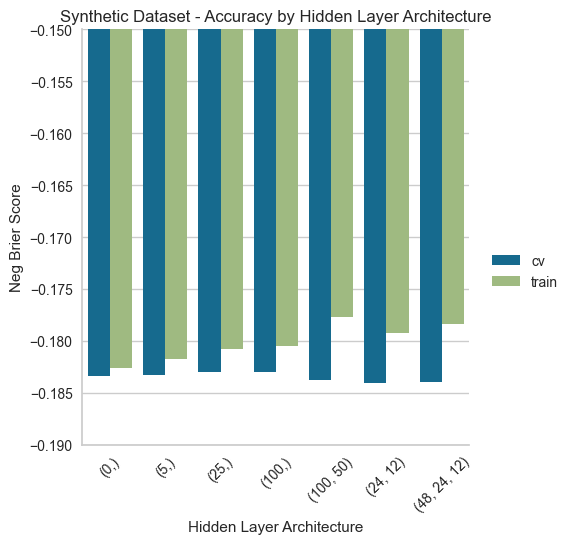

In [43]:
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns = ['Hidden Layer Architecture', 'cv_score', 'train_score'])

df1=df[['Hidden Layer Architecture', 'cv_score']].rename(columns={"cv_score": "score"})
df2=df[['Hidden Layer Architecture', 'train_score']].rename(columns={"train_score": "score"})

df1['score_type'] = 'cv'
df2['score_type'] = 'train'

final = pd.concat([df1, df2], axis=0)

import seaborn as sns

chart = sns.catplot(data=final, kind="bar", x="Hidden Layer Architecture", y="score", hue="score_type")

#chart.despine(left=True)
chart.set_axis_labels("", "Neg Brier Score")
chart.legend.set_title("")

plt.xticks(rotation=45)
plt.xlabel("Hidden Layer Architecture")
plt.ylim([-.19, -.15])
#plt.yticks(np.arange(0, 1, step = .1))
plt.title("Synthetic Dataset - Accuracy by Hidden Layer Architecture")
plt.savefig(fname='analysis')

In [45]:
final.sort_values(by='score', ascending=False)

,Hidden Layer Architecture,score,score_type
4,"(100, 50)",-0.177682,train
6,"(48, 24, 12)",-0.178412,train
5,"(24, 12)",-0.179278,train
3,"(100,)",-0.180503,train
2,"(25,)",-0.180792,train
1,"(5,)",-0.181765,train
0,"(0,)",-0.182636,train
3,"(100,)",-0.182980,cv
2,"(25,)",-0.183000,cv
1,"(5,)",-0.183274,cv


In [23]:
def plot_learning_curve(train, target, features, model, scoring, xlabel, ylabel, title, yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23):
    
    viz = LearningCurve(
        model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=-1, random_state=random_state)
    viz.fit(train[features], train[target])
    viz.ax.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if yticks:
        viz.ax.set_yticks(yticks)
    plt.show()

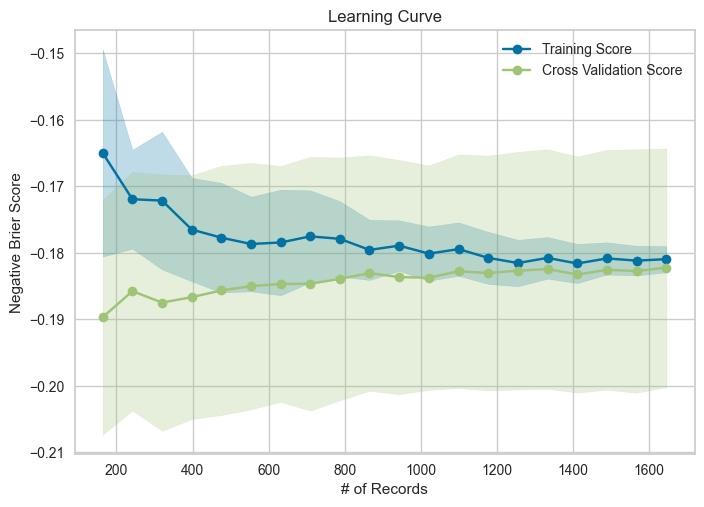

In [35]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=23)

from yellowbrick.model_selection import ValidationCurve, LearningCurve
plot_learning_curve(train, 'Outcome', features_sky_mens, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Neural Net", yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23)


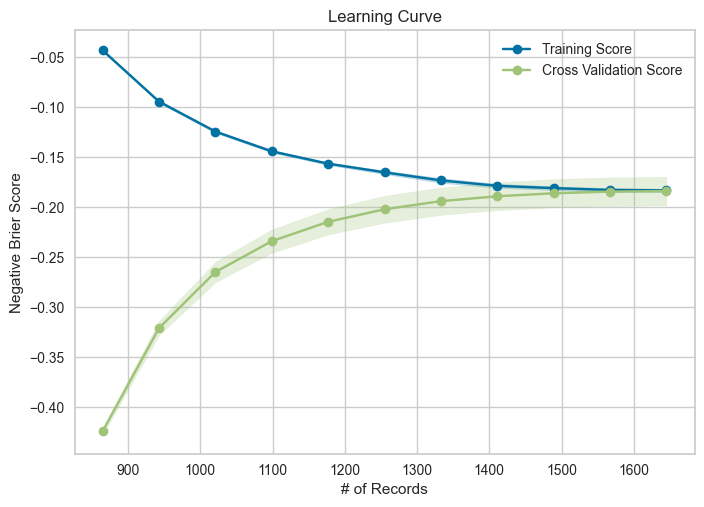

In [38]:
model = LogisticRegression(**best_param)

from yellowbrick.model_selection import ValidationCurve, LearningCurve
plot_learning_curve(train, 'Outcome', features_sky_mens, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Logreg", yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23)


In [31]:
#Logreg benchmark
clf = LogisticRegression(random_state = 0)
params = {'C': np.logspace(start=-5, stop=3, num=9), 'penalty': ['l2']}
clf = GridSearchCV(clf, params, scoring='neg_log_loss', refit=True)
X_train_scaled = StandardScaler().fit_transform(train[features_sky_mens])
clf.fit(X_train_scaled, train[target].astype(int))
best_param = clf.best_params_

model = LogisticRegression(**best_param)
scores = cross_validate(model, train[features_sky_mens], train[target].astype(int), cv=5, scoring='neg_brier_score', return_train_score=True)
cv_score = sum(scores['test_score']) / len(scores['test_score'])
train_score = sum(scores['train_score']) / len(scores['train_score'])

print(best_param)

{'C': 0.1, 'penalty': 'l2'}


### Predictions

In [ ]:
def make_predictions(to_predict_df, features, pred_suffix='', prediction_season=2023, min_train_season=2015):

    to_predict_df_train = to_predict_df[ (to_predict_df.Season >= min_train_season) 
                                        & (to_predict_df.Season < prediction_season) ].copy()

    to_predict_df_test = to_predict_df[ (to_predict_df.Season == prediction_season) ].copy()

    model = ModelPrediction()
    model.fit(to_predict_df_train[features], to_predict_df_train['Outcome'].astype(int))
    preds = model.predict_proba(to_predict_df_test[features])
    to_predict_df_test['model_preds_' + pred_suffix] = preds[:,1]

    return to_predict_df_test[['type', 'ID', 'Team1', 'Team2', 'model_preds_' + pred_suffix]]


def add_team_names(df, team_names):
    team_id1 = team_names.rename(columns = {'TeamID': 'Team1', 
                                            'TeamName':'Team1_Name'}).copy()
    team_id2 = team_names.rename(columns = {'TeamID': 'Team2', 'TeamName':'Team2_Name'}).copy()
    
    df = df.merge(team_id1[['Team1', 'Team1_Name']], on = ['Team1'], how = 'left')
    df = df.merge(team_id2[['Team2', 'Team2_Name']], on = ['Team2'], how = 'left')

    return df


In [ ]:
# 538 model
features_538 = ['t1_team_rating_538', 
        't2_team_rating_538']

# Only matchups in 538 dataset 
to_predict_538_mens = to_predict_mens[(~to_predict_mens.t1_team_rating_538.isna())
                    & (~to_predict_mens.t2_team_rating_538.isna())]

to_predict_538_womens = to_predict_womens[(~to_predict_womens.t1_team_rating_538.isna())
                    & (~to_predict_womens.t2_team_rating_538.isna())]

preds_538_mens = make_predictions(to_predict_538_mens, features_538, pred_suffix='538_mens')
preds_538_womens = make_predictions(to_predict_538_womens, features_538, pred_suffix='538_womens')

In [ ]:
# skyler model
features_sky_mens = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']

features_sky_womens = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin']

# Only tournament matchups
to_predict_sky_mens = to_predict_mens[(~to_predict_mens.seed_diff.isna())
                    & (~to_predict_mens.seed_diff.isna())].copy()

to_predict_sky_womens = to_predict_womens[(~to_predict_womens.seed_diff.isna())
                    & (~to_predict_womens.seed_diff.isna())].copy()

preds_sky_mens = make_predictions(to_predict_sky_mens, features_sky_mens, pred_suffix='sky_mens')

preds_sky_womens = make_predictions(to_predict_sky_womens, features_sky_womens, pred_suffix='sky_womens')


In [ ]:
to_predict_sky_mens.Season.unique()

In [ ]:
final_submission = to_predict[to_predict.type == 'Prediction']

In [ ]:
final_submission = final_submission.merge(preds_sky_mens[['ID', 'model_preds_sky_mens']], how='left', on='ID')
final_submission = final_submission.merge(preds_538_mens[['ID', 'model_preds_538_mens']], how='left', on='ID')

final_submission = final_submission.merge(preds_sky_womens[['ID', 'model_preds_sky_womens']], how='left', on='ID')
final_submission = final_submission.merge(preds_538_womens[['ID', 'model_preds_538_womens']], how='left', on='ID')

In [ ]:
final_submission['Pred_Blend'] = final_submission.model_preds_sky_mens * .3 + final_submission.model_preds_538_mens * .7


In [ ]:
# Submission 1 -- my model for mens, 538 for womens

final_submission['Pred_all_50'] = final_submission['Pred'].copy()

final_submission['Pred'] = np.where(final_submission.model_preds_sky_mens.notnull(), 
                                    final_submission.model_preds_sky_mens, 

                            np.where(final_submission.model_preds_538_womens.notnull(), 
                                    final_submission.model_preds_538_womens,
                                    
                            final_submission['Pred_all_50']))


In [ ]:
# Double checking that we have the right number of predictions to match the number of tourney games
    # The rest are all .5 because they involve non-tourney teams
final_submission[final_submission.Pred != .5].shape[0] / 2 == 68*67/2

In [ ]:
final_submission[['ID', 'Pred']].to_csv('../submissions/sub1_3_13.csv', index=False)

In [ ]:
# Submission 2 -- blend model for mens, 538 for womens

final_submission['Pred'] = np.where(final_submission.Pred_Blend.notnull(), 
                                    final_submission.Pred_Blend, 

                            np.where(final_submission.model_preds_538_womens.notnull(), 
                                    final_submission.model_preds_538_womens,
                                    
                            final_submission['Pred_all_50']))


In [ ]:
# Double checking that we have the right number of predictions to match the number of tourney games
    # The rest are all .5 because they involve non-tourney teams
final_submission[final_submission.Pred != .5].shape[0] / 2 == 68*67/2

In [ ]:
final_submission[['ID', 'Pred']].to_csv('../submissions/sub2_3_13.csv', index=False)

### Exploring Predictions

In [ ]:
sample = final_submission[ (final_submission.Pred_Blend.notnull()) & (final_submission.Gender == 'M')]
sample = add_team_names(sample, mteams)

In [ ]:
mteams[mteams.TeamName == 'Duke']

In [ ]:
sample[
    (sample.Team1_Name.str.contains('Michigan S'))
    & 
    (sample.Team2_Name.str.contains('Tenn'))
    ]

In [ ]:
experts[experts.ID == '2023_1277_1397']

In [ ]:
experts = pd.read_csv('../data/ExpertsMedianSubmission.csv')

### Validation

In [ ]:
features = [
    't1_team_rating_538', 
       't2_team_rating_538']

to_predict_sky_mens_train = to_predict_sky_mens[(to_predict_sky_mens.Season > 2015) &
                                                    (to_predict_sky_mens.Season < 2023)].copy()

mv_538 = ModelValidation(to_predict_sky_mens_train, features, min_training_size=1, select_features=False)
mv_538.validate()

In [ ]:
mv.avg_validation_score

In [ ]:
features_sky_mens = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']

to_predict_sky_mens_train = to_predict_sky_mens[(to_predict_sky_mens.Season < 2023)].copy()

mv_sky = ModelValidation(to_predict_sky_mens_train, features_sky_mens, min_training_size=1, select_features=False)
mv_sky.validate()

In [ ]:
mv.avg_validation_score

In [ ]:
# Analyzing Ensemble Performance

all_538 = []
all_sky = []
all_combined = []
df_list = []

for preds_538, preds_sky, year in list(zip(mv_538.fold_preds, mv_sky.fold_preds[-5:], [2017, 2018, 2019, 2021, 2022])):
    
    preds_538_pred = preds_538[:,1]
    preds_sky_pred = preds_sky[:,1]
    avg_pred = (preds_538_pred * .7) + (preds_sky_pred * .3)

    tmp_df = to_predict_sky_mens[to_predict_sky_mens.Season == year].copy()
    tmp_df['538_pred'] = preds_538_pred
    tmp_df['sky_pred'] = preds_sky_pred
    df_list.append(tmp_df)

    label = to_predict_sky_mens[to_predict_sky_mens.Season == year].Outcome.astype(int)

    all_538.append(brier_score_loss(label, preds_538_pred))
    all_sky.append(brier_score_loss(label, preds_sky_pred))
    all_combined.append(brier_score_loss(label, avg_pred))


In [ ]:
# Analyzing where models to do better / worse
analysis_df = pd.concat(df_list, axis=0)

In [ ]:
analysis_df['pred_bucket_sky'] = pd.qcut(analysis_df.sky_pred, q=10)
analysis_df['pred_bucket_538'] = pd.qcut(analysis_df['538_pred'], q=10)

In [ ]:
analysis_df



In [ ]:
scores = []

for index, row in analysis_df[['t1_Seed', 't2_Seed']].drop_duplicates().iterrows():
    
    t1seed = row['t1_Seed']
    t2seed = row['t2_Seed']

    tmp = analysis_df[ (analysis_df.t1_Seed == t1seed)
                      & (analysis_df.t2_Seed == t2seed)]

    scores.append((t1seed, t2seed, brier_score_loss(tmp['Outcome'].astype(int), tmp['sky_pred']), tmp.shape[0]))



In [ ]:
# Feels like not enough data to evaluate -- prob driven by 1 or 2 "bad" games
seed_analysis = pd.DataFrame(scores,columns=['seed1', 'seed2', 'score', 'n_records'])
seed_analysis[seed_analysis.n_records > 8].sort_values(by='score', ascending=False)

In [ ]:
8

In [ ]:
scores = []

analysis_df.sort_values(by='pred_bucket_538', ascending=False, inplace=True)

for i in list(analysis_df.pred_bucket_538.unique()):
    
    tmp = analysis_df[analysis_df.pred_bucket_538 == i]

    y_true = tmp['Outcome']
    scores.append((i, brier_score_loss(tmp['Outcome'].astype(int), tmp['538_pred'])))

#analysis_df.groupby('pred_bucket_sky').apply()

In [ ]:
scores = []

analysis_df.sort_values(by='pred_bucket_538', ascending=False, inplace=True)

for i in list(analysis_df.pred_bucket_538.unique()):
    
    tmp = analysis_df[analysis_df.pred_bucket_538 == i]

    y_true = tmp['Outcome']
    scores.append((i, brier_score_loss(tmp['Outcome'].astype(int), tmp['538_pred'])))

#analysis_df.groupby('pred_bucket_sky').apply()

In [ ]:
# 538 scores
scores

In [ ]:
# my scores 
scores

In [ ]:
tmp.columns

In [ ]:
all_538, all_sky, all_combined

In [ ]:
sum(all_538) / len(all_538), sum(all_sky) / len(all_sky), sum(all_combined) / len(all_combined)

In [ ]:
preds_sky_pred

In [ ]:
features = [
    't1_team_rating_538', 
       't2_team_rating_538']

to_predict_sky_womens_train = to_predict_sky_womens[(to_predict_sky_womens.Season > 2015) &
                                                    (to_predict_sky_womens.Season < 2023)].copy()

mv = ModelValidation(to_predict_sky_womens_train, features, min_training_size=1, select_features=False)
mv.validate()

In [ ]:
mv.avg_validation_score

In [ ]:
features = ['seed_diff', 
't1_adj_margin', 't2_adj_margin']

to_predict_sky_womens_train = to_predict_sky_womens[
                                            (to_predict_sky_womens.Season > 2015) &
                                            (to_predict_sky_womens.Season < 2023)].copy()

mv = ModelValidation(to_predict_sky_womens_train, features, min_training_size=1, select_features=False)
mv.validate()

In [ ]:
mv.avg_validation_score

In [ ]:
features = [
    't1_team_rating_538', 
       't2_team_rating_538']


mv = ModelValidation(to_predict_538_train, features, min_training_size=1, select_features=False)
mv.validate()



In [ ]:
mv.avg_validation_score

In [ ]:
to_predict_womens = feature_engineering.TournamentSeed(tourney_seeds=seeds_w).add(to_predict_womens)
to_predict_womens = feature_engineering.Efficiency(games=regular_season_games_w, away_bonus=0).add(to_predict_womens)


In [ ]:
sys_counts = []

for s in rankings.SystemName.unique():
    season_count = len(list(rankings[rankings.SystemName == s].Season.unique()))
    sys_counts.append((s, season_count))
    


In [ ]:
df = pd.DataFrame(sys_counts, columns=['system', 'count'])
df[df['count'] == 21]

# could build model using just these rankings to produce ranking prediction

### Building and Testing

In [ ]:
mens = to_predict[to_predict.Gender == 'M']

In [ ]:
features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']



In [ ]:
tmp = tourney_games
X = tmp[features]
y = tmp['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [ ]:
find_best_params(X_train, y_train)

In [ ]:
def find_best_params(X_train, y_train):
    clf = LogisticRegression(random_state = 0)
    params = {'C': np.logspace(start=-5, stop=3, num=50), 'penalty': ['l2']}
    clf = GridSearchCV(clf, params, scoring='neg_brier_score', refit=True)
    X_train_scaled = StandardScaler().fit_transform(X_train)
    clf.fit(X_train_scaled, y_train)
    best_params = clf.best_params_
    return best_params


In [ ]:
kp_features = ['t1_adjem', 't1_adjo', 't1_adjo_rank', 't1_adjd', 't1_adjd_rank',
       't1_adjt', 't1_adjt_rank', 't1_luck', 't1_luck_rank', 't1_sos_adjem',
       't1_sos_adjem_rank', 't1_sos_opp_o', 't1_sos_opp_o_rank',
       't1_sos_opp_d', 't1_sos_opp_d_rank', 
       't1_ncsos_adjem_rank', 't2_adjem', 't2_adjo', 't2_adjo_rank', 't2_adjd',
       't2_adjd_rank', 't2_adjt', 't2_adjt_rank', 't2_luck', 't2_luck_rank',
       't2_sos_adjem', 't2_sos_adjem_rank', 't2_sos_opp_o',
       't2_sos_opp_o_rank', 't2_sos_opp_d', 't2_sos_opp_d_rank',
      't2_ncsos_adjem_rank']


my_features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
              't1_OrdinalRank', 't2_OrdinalRank',
                't1_final_rank', 't2_final_rank']


all_features = kp_features + my_features




In [ ]:
class ParameterFinder():

    def parameter_grid_search(self, X_train, y_train):
            '''gets best parameters using cross validation'''

            clf = LogisticRegression(random_state = 0)
            params = {'C': np.logspace(start=-5, stop=3, num=50), 'penalty': ['l2']}
            clf = GridSearchCV(clf, params, scoring='neg_brier_score', refit=True)
            X_train_scaled = StandardScaler().fit_transform(X_train)
            clf.fit(X_train_scaled, y_train)
            best_params = clf.best_params_
            return best_params


In [ ]:
class ModelPrediction:

    def __init__(self):
        self.trained_model=None

    def grid_search_get_best_params(self, X_train, y_train):

        clf = LogisticRegression(random_state = 0)
        params = {'C': np.logspace(start=-5, stop=3, num=50), 'penalty': ['l2']}
        clf = GridSearchCV(clf, params, scoring='neg_brier_score', refit=True)
        X_train_scaled = StandardScaler().fit_transform(X_train)
        clf.fit(X_train_scaled, y_train)
        best_params = clf.best_params_
        return best_params 

    def fit(self, X_train, y_train, params=None):
        ''' train model on unseen data '''

        parameters_to_use = None

        if params is not None: 
            self.params_to_use = params
        
        else:
            self.params_to_use = self.grid_search_get_best_params(X_train, y_train)
        
        lr = Pipeline([('scale', StandardScaler()),('logreg', LogisticRegression(**self.params_to_use))])
        lr.fit(X_train, y_train)
        
        self.trained_model = lr

      
    def predict_proba(self, X_test):
        ''' predict dataset using trained model'''
        preds = self.trained_model.predict_proba(X_test)
        return preds


In [ ]:
class ModelValidation:

    def __init__(self, tourney_games, available_features, min_training_size=5, select_features=True):
        self.tourney_games=tourney_games
        self.available_features=available_features
        self.select_features=select_features
        self.min_training_size = min_training_size

    def grid_search_get_best_params(self, X_train, y_train):

        clf = LogisticRegression(random_state = 0)
        params = {'C': np.logspace(start=-5, stop=3, num=50), 'penalty': ['l2']}
        clf = GridSearchCV(clf, params, scoring='neg_brier_score', refit=True)
        X_train_scaled = StandardScaler().fit_transform(X_train)
        clf.fit(X_train_scaled, y_train)
        best_params = clf.best_params_
        return best_params 


    def hyperopt_get_best_params(self, X_train, y_train):

        hp_search_space = {'C': hp.uniform('C', .0001, 1000)}
        oms = OptimizedModelSelector(
                              n_rounds=5
                            , X=X_train
                            , y=y_train
                            , starting_model=LogisticRegression
                            , starting_features=self.available_features
                            , hyper_parameter_space=hp_search_space)
        oms.run()

        return oms.features, oms.selected_params
                
    def validate(self):
        ''' returns estimate for model performance using shifted validation'''

        scores = []
        tourney_games = self.tourney_games
        self.fold_preds = []
        
        for n, season in enumerate(tourney_games.Season.unique()):
            
            if n >= self.min_training_size and n < len(tourney_games.Season.unique()):

                print(season)

                train = tourney_games[tourney_games.Season < season]
                test = tourney_games[tourney_games.Season == season]

                X_train = train[self.available_features]
                X_test = test[self.available_features]
                y_train = train['Outcome'].astype(int)
                y_test = test['Outcome'].astype(int)

                if self.select_features:
                    features, params = self.hyperopt_get_best_params(X_train, y_train)
                    print(features)

                else:
                    features=self.available_features
                    params=self.grid_search_get_best_params(X_train, y_train)

                lr = Pipeline([('scale', StandardScaler()),('logreg', LogisticRegression(**params))])
                lr.fit(X_train[features], y_train)

                y_prob = lr.predict_proba(X_test[features])
                self.fold_preds.append(y_prob)
                loss = brier_score_loss(y_test, y_prob[:,1])
                print(loss)
                scores.append((season, loss))

        self.validation_df = pd.DataFrame(scores, columns = ['season', 'score']).sort_values(by = 'score')
        self.avg_validation_score = self.validation_df.score.mean()


In [ ]:
from sklearn.model_selection import cross_val_score

class OptimizedModelSelector:

    def __init__(self, n_rounds, X, y, starting_model, starting_features, hyper_parameter_space, cv_folds=5, default_feature='seed_diff'):
        self.starting_model=starting_model
        self.starting_features=starting_features
        self.hyper_parameter_space=hyper_parameter_space
        self.X = X.copy()
        self.y = y.copy()
        self.folds=cv_folds
        self.n_rounds=n_rounds
        self.default_feature='seed_diff' # feature to use in case model selector tries to be stupid and use 0 features
        self.round_metrics = {} # key is the loss, value is a dict of features and hyperparams

    def objective(self, params):

        selected_features = []
        param_dict = {}

        for i, j in params.items():
            if ('_var' in i) and (j == 1):
                selected_features.append(i)
            elif ('_var' not in i):
                param_dict[i] = j + .000000000001 # avoid divide by zero

        if len(selected_features) == 0:
            selected_features = [self.default_feature + '_var']

        model = Pipeline([('scale', StandardScaler()), ('model', self.starting_model(**param_dict, random_state=0,
                                                                                max_iter=1000))])
       
        cv_scores = cross_val_score(model, self.X[selected_features], self.y, scoring='neg_brier_score', cv=self.folds,
                                error_score='raise', verbose=0)

        return -1 * (sum(cv_scores) / len(cv_scores))
    
    def get_features_and_params_from_best(self, best):

        self.features = []
        self.selected_params = {}
        
        for k,v in best.items():
            if v == 1 and k not in self.hyper_parameter_space.keys():
                self.features.append(k)
            if k in self.hyper_parameter_space.keys():
                self.selected_params[k] = v

    def run(self):

        search_space = self.hyper_parameter_space
        self.features = self.starting_features

        for round in range(self.n_rounds):

            search_space = {}
            
            for k,v in self.hyper_parameter_space.items():
                search_space[k] = v
    
            for col in self.features:
                self.X.rename(columns={col:col+'_var'}, inplace=True)
                search_space[col + '_var'] = hp.choice(col, [0,1])
            
            trials = Trials()

            # print(search_space)

            best = fmin(self.objective, search_space, algo=tpe.suggest,
                                max_evals=100, trials=trials)

            best_loss = trials.best_trial['result']['loss']
            self.get_features_and_params_from_best(best)

            self.round_metrics[best_loss] = {'features': self.features,
                                            'params': self.selected_params}

        # find best score across all rounds, set features / parameters associated with round
        best_score = min(self.round_metrics.keys())
        self.features = self.round_metrics[best_score]['features']
        self.selected_params = self.round_metrics[best_score]['params']




In [ ]:
t = to_predict_mens[ (to_predict_mens.Season > 2010)
                & (to_predict_mens.Season < 2023)]

hp_search_space = {'C': hp.quniform('C', .0001, 1000, 1)}

all_features = my_features.copy()

oms = OptimizedModelSelector(X=t
                       , n_rounds = 2
                       , y=t['Outcome'].astype(int)
                       , starting_model=LogisticRegression
                       , starting_features=all_features
                       , hyper_parameter_space=hp_search_space)

In [ ]:
t = to_predict_mens[ (to_predict_mens.Season > 2010)
                & (to_predict_mens.Season < 2023)]


features = all_features
# selected = ['t1_OrdinalRank', 't1_adj_margin', 't1_ncsos_adjem_rank', 't1_sos_adjem_rank', 't1_sos_opp_o_rank', 't2_OrdinalRank', 't2_adj_margin', 't2_adjt_rank', 't2_sos_opp_d']

selected = ['t1_OrdinalRank',
't2_OrdinalRank',
't1_adj_margin', 
't2_adj_margin',
't1_sos_adjem_rank',
't2_sos_adjem_rank',
't1_ncsos_adjem_rank',
't2_ncsos_adjem_rank',
't2_adjt_rank',
't1_adjt_rank',
't1_final_rank',
't2_final_rank',
'seed_diff'
]


mv = ModelValidation(t, selected, select_features=False)
mv.validate()


In [ ]:
mv.validation_df

In [ ]:
mv.avg_validation_score

In [ ]:
mv.avg_validation_score

In [ ]:
tmp = t[['Season', 'Team1', 'Team2','t1_adjem', 't1_adj_margin', 't2_adjem', 't2_adj_margin']]

In [ ]:
tmp['t1_diff'] = abs(tmp['t1_adjem'] - tmp['t1_adj_margin'])
tmp['t2_diff'] = abs(tmp['t2_adjem'] - tmp['t2_adj_margin'])

In [ ]:
tmp.sort_values(by = 't1_diff', ascending=False)[['Season', 'Team1', 't1_adj_margin', 
                                                  't1_adjem', 't1_diff']].drop_duplicates()

In [ ]:
mteams[mteams.TeamID == 1276]

In [ ]:
tmp[tmp.Season == 2021].sort_values(by = 't1_adj_margin', ascending = False).drop_duplicates(subset=['Team1'])

In [ ]:
t[t.Outcome == 'unknown']

In [ ]:
features_w = ['seed_diff',
 't1_adj_margin',
 't2_adj_margin']

In [ ]:
mv = ModelValidation(tourney_games_w, features_w)
mv.validate()

In [ ]:
mv.avg_validation_score

In [ ]:
scores_df = pd.DataFrame(loss_score, columns = ['Season', 'Score']).sort_values(by = 'Score')
scores_df

In [ ]:
# just seeds
scores_df.Score.mean()

In [ ]:
# just seeds
scores_df.Score.mean()

In [ ]:
# add efficiency
scores_df.Score.mean()

In [ ]:
# add ordinal rank
scores_df.Score.mean()

In [ ]:
# all
scores_df.Score.mean()

In [ ]:
X = to_pred_games[feature_list].values
y = to_pred_games['Outcome'].values.ravel()
ss = StandardScaler()

# X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Grid search to get best params
clf = LogisticRegression(random_state = 0)
params = {'C': np.logspace(start=-5, stop=3, num=9), 'penalty': ['l2', 'l1']}
clf = GridSearchCV(clf, params, scoring='neg_log_loss', refit=True)
X_train_scaled = StandardScaler().fit_transform(X_train)
clf.fit(X_train_scaled, y_train)
best_param = clf.best_params_


In [ ]:
#Cross validation
seasons = list(to_pred_games.Season.unique())

log_loss_list = []

for test_season in seasons:
    
    train_seasons = seasons.copy()
    train_seasons.remove(test_season)
 
    X_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)][feature_list].values
    X_test = to_pred_games[to_pred_games.Season == test_season][feature_list].values

    y_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)]['Outcome'].values.ravel()
    y_test = to_pred_games[to_pred_games.Season == test_season]['Outcome'].values.ravel()
    
    logreg = Pipeline([('scale', StandardScaler()),('logreg', LogisticRegression(**best_param))])
    logreg.fit(X_train, y_train)

    #Evaluate score on test set 
    y_pred = logreg.predict_proba(X_test)
    
    ll = log_loss(y_test, y_pred)
    log_loss_list.append(ll)
    
    
print('avg. log loss: {}'.format(sum(log_loss_list) / len(log_loss_list)))
print('min log loss: {}'.format(min(log_loss_list)))
print('max log loss: {}'.format(max(log_loss_list)))
print('std dev log loss: {}'.format(statistics.stdev(log_loss_list)))
print(log_loss_list)
    

In [ ]:
to_predict=SubmissionSetup(sub, tourney_games, tourney_games_w, mteams).setup()

In [ ]:
to_predict.groupby(['type', 'Gender']).count()

In [ ]:
to_predict[to_predict.type == ]

In [ ]:
sub.merge(mteams, how='left', )

In [ ]:
tourney_games.head()

### Create data

### Set up

In [ ]:
pd.set_option('max_columns', 1000)
all_games.head()

In [ ]:
all_games = all_games.fillna(0)

#remove tournament games we are predicting on 
# to_pred_games = all_games[(all_games.Season < 2016)] #this is for the first stage
to_pred_games = all_games[(all_games.Season < 2022)] #this is for the second stage




In [ ]:

feature_list = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank',
     't1_adj_margin_3',
 't2_adj_margin_3',
     't1_adj_margin_2',
 't2_adj_margin_2',
     't1_adj_margin_10',
 't2_adj_margin_10',
      't1_num_wins',
    't2_num_wins',
     't1_adj_margin_7',
 't2_adj_margin_7',
     't1_won_conf_tournament',
    't2_won_conf_tournament',
      't1_num_losses',
    't2_num_losses',
     't1_adj_margin_5',
 't2_adj_margin_5',
    'num_wins_diff',
]

feature_list = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank',
]


           

#### Cross validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
X = to_pred_games[feature_list].values
y = to_pred_games['Outcome'].values.ravel()
ss = StandardScaler()

# X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Grid search to get best params
clf = LogisticRegression(random_state = 0)
params = {'C': np.logspace(start=-5, stop=3, num=9), 'penalty': ['l2', 'l1']}
clf = GridSearchCV(clf, params, scoring='neg_log_loss', refit=True)
X_train_scaled = StandardScaler().fit_transform(X_train)
clf.fit(X_train_scaled, y_train)
best_param = clf.best_params_


#### Logistic Regression

In [ ]:
#Grid search to get best params
clf = LogisticRegression(random_state = 0)
params = {'C': np.logspace(start=-5, stop=3, num=9), 'penalty': ['l2', 'l1']}
clf = GridSearchCV(clf, params, scoring='neg_log_loss', refit=True)
X_train_scaled = StandardScaler().fit_transform(X_train)
clf.fit(X_train_scaled, y_train)
best_param = clf.best_params_

# #Use best params to train final model
# logreg = Pipeline([('scale', StandardScaler()),('logreg', LogisticRegression(**best_param))])
# logreg.fit(X_train, y_train)

#Evaluate score on test set 
#y_pred = logreg.predict_proba(X_test)
#log_loss(y_test, y_pred)



In [ ]:
LogisticRegression(**best_param)

In [ ]:
import statistics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [ ]:
seasons = list(all_games.Season.unique())
scores = [0.5223775658655162, 0.5035419334769029, 0.4938799971523059, 0.583826101324787, 0.4297945006936753, 0.4833622866501298, 0.5105272087220717, 0.5053560596048409, 0.6138812776789054, 0.5821446004893247, 0.5625780606741233, 0.5374232777449158, 0.5058912971422388]
pd.DataFrame(list(zip(seasons, scores)))


In [ ]:
#Cross validation
seasons = list(to_pred_games.Season.unique())

log_loss_list = []

for test_season in seasons:
    
    train_seasons = seasons.copy()
    train_seasons.remove(test_season)
 
    X_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)][feature_list].values
    X_test = to_pred_games[to_pred_games.Season == test_season][feature_list].values

    y_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)]['Outcome'].values.ravel()
    y_test = to_pred_games[to_pred_games.Season == test_season]['Outcome'].values.ravel()
    
    logreg = Pipeline([('scale', StandardScaler()),('logreg', LogisticRegression(**best_param))])
    logreg.fit(X_train, y_train)

    #Evaluate score on test set 
    y_pred = logreg.predict_proba(X_test)
    
    ll = log_loss(y_test, y_pred)
    log_loss_list.append(ll)
    
    
print('avg. log loss: {}'.format(sum(log_loss_list) / len(log_loss_list)))
print('min log loss: {}'.format(min(log_loss_list)))
print('max log loss: {}'.format(max(log_loss_list)))
print('std dev log loss: {}'.format(statistics.stdev(log_loss_list)))
print(log_loss_list)
    

In [ ]:
#fit on entire dataset
logreg = Pipeline([('scale', StandardScaler()),('logreg', LogisticRegression(**best_param))])
logreg.fit(X, y)

avg. log loss: 0.5377196208726289
min log loss: 0.4527681615412048
max log loss: 0.6301372973190598
std dev log loss: 0.04826156092665253
[0.5229902686047858, 0.5236486146281775, 0.5158111793350595, 0.56923309326896, 0.4527681615412048, 0.483523972814316, 0.5005711494650689, 0.5390678057159176, 0.6301372973190598, 0.562545719196487, 0.5826151696256913, 0.5697230189568193]


In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier

In [ ]:
#Grid search to get best params
clf = XGBClassifier(random_state = 0)

params = {'min_child_weight': [5],
        'gamma': [5, 10],
        'subsample': [0.8],
        'colsample_bytree': [0.4, 0.6],
        'max_depth': [1, 2, 3, 10, 20, 30, 50]
        }

clf = GridSearchCV(clf, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
best_param = clf.best_params_


In [ ]:
best_param = clf.best_params_


In [ ]:
best_param = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.0003,
              'max_depth': 5,
              'subsample': 1,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight':3,
              'gamma':0.25,
              'n_estimators':500,
              'verbosity':2
              }

In [ ]:
#Cross validation
seasons = list(to_pred_games.Season.unique())

log_loss_list = []

for test_season in seasons:
    
    train_seasons = seasons.copy()
    train_seasons.remove(test_season)
 
    X_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)][feature_list].values
    X_test = to_pred_games[to_pred_games.Season == test_season][feature_list].values

    y_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)]['Outcome'].values.ravel()
    y_test = to_pred_games[to_pred_games.Season == test_season]['Outcome'].values.ravel()
    
    clf = XGBClassifier(**best_param)
    clf.fit(X_train, y_train)

    #Evaluate score on test set 
    y_pred = clf.predict_proba(X_test)
    
    ll = log_loss(y_test, y_pred)
    log_loss_list.append(ll)
    
    
print('avg. log loss: {}'.format(sum(log_loss_list) / len(log_loss_list)))
print('min log loss: {}'.format(min(log_loss_list)))
print('max log loss: {}'.format(max(log_loss_list)))
print('std dev log loss: {}'.format(statistics.stdev(log_loss_list)))
print(log_loss_list)
    

#### SVC

In [ ]:
''' 
from sklearn import svm
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
clf = GridSearchCV(svm.SVC(kernel='rbf', probability = True), param_grid, cv=5)
clf.fit(X, y)
clf.fit(X_train, y_train)
best_param = clf.best_params_


svc_ = svm.SVC(**best_param, probability = True)
svc_.fit(X_train, y_train)

y_pred = svc_.predict_proba(X_test)
log_loss(y_test, y_pred)
''' 


#### Random Forest

In [ ]:
best_param = {'max_depth':10, 'min_samples_leaf':5, 'n_estimators':1000}

In [ ]:
#Grid search to get best params
clf = RandomForestClassifier(random_state = 0)

params = {'min_samples_leaf': [1, 5, 15, 25, 50, 80, 100], 
          'bootstrap': [True, False],
          'max_depth': [1, 3, 5, 10, 20, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [2, 5, 10],
         }

clf = GridSearchCV(clf, params, scoring='neg_log_loss', refit=True, verbose = 100)
clf.fit(X_train, y_train)
best_param = clf.best_params_



In [ ]:
#Cross validation
seasons = list(to_pred_games.Season.unique())

log_loss_list = []

for test_season in seasons:
    
    train_seasons = seasons.copy()
    train_seasons.remove(test_season)
 
    X_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)][feature_list].values
    X_test = to_pred_games[to_pred_games.Season == test_season][feature_list].values

    y_train = to_pred_games[to_pred_games['Season'].isin(train_seasons)]['Outcome'].values.ravel()
    y_test = to_pred_games[to_pred_games.Season == test_season]['Outcome'].values.ravel()
    
    rf = Pipeline([('scale', StandardScaler()),('logreg', RandomForestClassifier(**best_param))])
    rf.fit(X_train, y_train)

    #Evaluate score on test set 
    y_pred = rf.predict_proba(X_test)
    
    ll = log_loss(y_test, y_pred)
    print(ll)
    log_loss_list.append(ll)
    
    
print('avg. log loss: {}'.format(sum(log_loss_list) / len(log_loss_list)))
print('min log loss: {}'.format(min(log_loss_list)))
print('max log loss: {}'.format(max(log_loss_list)))
print('std dev log loss: {}'.format(statistics.stdev(log_loss_list)))
print(log_loss_list)
    

In [ ]:
#0.516114759994771


# feature_list = ['seed_diff',  
#                 't1_adj_margin','t2_adj_margin',
#                 't1_final_rank', 't2_final_rank',
#                 't1_OrdinalRank', 't2_OrdinalRank',
#                 't1_adj_margin_1',
#        't1_adj_margin_3', 't1_adj_margin_4','t1_adj_margin_10',
#        't2_adj_margin_1', 't2_adj_margin_3',
#        't2_adj_margin_4', 
#        't2_adj_margin_10']

In [ ]:
best_param['n_estimators'] = 1000

In [ ]:
#fit on entire dataset
rf = RandomForestClassifier(**best_param)
rf.fit(X, y)

In [ ]:
best_param

### Output model and data

In [ ]:
#all_games.to_csv('output/all_games.csv')

In [ ]:
import pickle
    
with open("model/logreg.pkl", "wb") as file: 
    pickle.dump(logreg, file)

# with open("model/rf.pkl", "wb") as file: 
#     pickle.dump(rf, file)  

    

In [ ]:
logreg